# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [70]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass
from HANKmodel_baseline import HANKModelClass_baseline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [71]:
#print(model)
model = HANKModelClass(name='two_sector')
model_baseline = HANKModelClass_baseline(name='one_sector')
#model.print_unpack_varlist()

In [ ]:
#model = HANKModelClass(name='baseline')
#model.find_ss(do_print=False)
#par = model.par
#ss = model.ss
#path = model.path
#sim = model.sim
#model.test_hh_path()
#model.compute_jacs(do_print=False)
#par.jump_istar = 0.0 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model.find_transition_path(do_print=False) #all
#paths = ['pm_N','pi_L','pi_N','p_N','p_L','P_hh','P','Q','Q_check'] #Show all graphs
#lvl_value = ['i','pi_L','pi_N','r','pi','tau','Q','Q_check','P_hh'] #Show all push
#model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=4)

# Step 1: Steady state

In [60]:
model.find_ss(do_print=True)

steady state found in 13.6 secs
 Q   =   0.7189
 P   =   0.8105
 Z_N   =   0.3018
 Z_L   =   1.0441
 M_N   =   0.2949
 M_L   =   0.0960
 N_L   =   0.4173
 N_N   =   0.5234
 HH_ell   =   1.1211
 wage N  =   0.3131
 wage L  =   0.4356
 par.varphi   =   1.0000
 par.beta   =   0.9706
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =   0.00000000


In [61]:
model_baseline.find_ss(do_print=True)
model_baseline.compute_jacs()

Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.6675,	 M = 0.4082,	 beta = 0.9807,	 N = 0.9663
Z = 0.7382,	 M = 0.4082,	 beta = 0.9767,	 N = 0.8737
Z = 0.7824,	 M = 0.4082,	 beta = 0.9731,	 N = 0.8243
Z = 0.7867,	 M = 0.4082,	 beta = 0.9716,	 N = 0.8198
Z = 0.7794,	 M = 0.4082,	 beta = 0.9712,	 N = 0.8275
Z = 0.7730,	 M = 0.4082,	 beta = 0.9711,	 N = 0.8343
Z = 0.7680,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8398
Z = 0.7661,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8419
Z = 0.7662,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8418
Z = 0.7664,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8416
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 

Distribution graphs:

In [72]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')
print(f'wage share, necessities production: (in the data = 37.3%) = {(ss.N_N*ss.w_N/(ss.M_N*ss.pm_N+ss.N_N*ss.w_N)):8.4f}')
print(f'wage share, luxuries production: (in the data =69.2%) = {(ss.N_L*ss.w_L/(ss.M_L*ss.pm_L+ss.N_L*ss.w_L)):8.4f}')

Average expenditures share on luxuries (in the data = 51.8%) =      nan
Average Subsistence share of expenditures (in the data = 22.4%) =      nan
Lowest income household subsistence share of expenditures (in the data = 43,5%) =      nan
Average expenditures share on necessities for the lowest income households (in the data = 70.5%): =      nan
Average expenditures share on necessities (in the data = 48.2%) =      nan
Average expenditures share on necessities, net of subsistence (in the data = 33.2%) =      nan
wage share, necessities production: (in the data = 37.3%) =      nan
wage share, luxuries production: (in the data =69.2%) =      nan


MPCs for different values of Chi and c_bar

In [ ]:

model_MPC = model.copy()

c_bar_list = [0.0, 0.025, 0.05, 0.075, 0.10]
chi_list = [0.0, 0.025, 0.05, 0.075, 0.10]

MPC_matrix = np.empty(shape=(len(c_bar_list),len(chi_list)))

for i,c_bar in enumerate(c_bar_list):
    model_MPC.par.c_bar = c_bar
    
    for j,chi in enumerate(chi_list):
        model_MPC.par.chi = chi
        
        model_MPC.find_ss()

        model_MPC.MPC = np.zeros(model_MPC.ss.D.shape)
        m_diff = (1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,1:]-(1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,:-1]
        model_MPC.MPC[:,:,:-1] = (model_MPC.ss.c[:,:,1:]-model_MPC.ss.c[:,:,:-1])/m_diff
        model_MPC.MPC[:,:,-1] = model_MPC.MPC[:,:,-1] # assuming constant MPC at end
        model_MPC.mean_MPC = np.sum(model_MPC.MPC*model_MPC.ss.D)
        model_MPC.mean_MPC_ann = 1-(1-model_MPC.mean_MPC)**4
        MPC_matrix[j,i] = model_MPC.mean_MPC_ann
        print(f'mean MPC - c_bar = {c_bar:.3f}, chi = {chi:.3f} : {model_MPC.mean_MPC:.3f} [annual: {model_MPC.mean_MPC_ann:.3f}]')

df_mpc = pd.DataFrame(MPC_matrix, columns=c_bar_list, index=chi_list)
print(df_mpc.to_latex())


Steady state values

In [ ]:
var_list = ['Y','N','M','mc','d','C','w','pm'] 
var_dict = vars(ss)
var_dict_baseline = vars(model_baseline.ss)
values_N = [round(var_dict[i+'_N'],3) for i in var_list]
values_L = [round(var_dict[i+'_L'],3) for i in var_list]
values_baseline = [round(var_dict_baseline[i],3) for i in var_list]
ss_values_df = pd.DataFrame(list(zip(values_baseline,values_N,values_L)), columns=['One-Sector','Sector N','Sector L'], index=var_list)
print(ss_values_df.to_latex())


Steady State graphs

In [ ]:
a_max = 500


MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'Mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')
fig = plt.figure(figsize=(8,8),dpi=100)

# a. income/productivity
ax = fig.add_subplot(3,2,1)
ax.set_title('Productivity')
y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])
ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(3,2,2)
ax.set_title('Savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < a_max
ax = fig.add_subplot(3,2,3)
ax.set_title('Marginal Propensity to Consume')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')
ax.set_xscale('symlog')

# D. labor supply
I = par.a_grid < a_max
ax = fig.add_subplot(3,2,4)
ax.set_title('Labor Supply')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')
ax.set_xscale('symlog')

# a. necessity consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(3,2,5)
ax.set_title('Consumption Share (Necessities)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.c_N[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')
#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')
ax.set_xscale('symlog')

# a. luxury consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(3,2,6)
ax.set_title('Consumption Share (Luxuries)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.Q*model.ss.c_L[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')

#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')
ax.set_xscale('symlog')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

In [ ]:
model.test_hh_path()

**Full transition path:**

In [ ]:
model.test_path()

In [ ]:
model.compute_jacs(do_print=True)
#model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Plot transitions

## Find transition path 1 - Monetary Policy shock

In [ ]:
par.jump_istar = 0.0025 # 25 BP Monetary policy shock
par.jump_pm_N     = 0.0 # cost push shock
model.find_transition_path(do_print=False) #all
paths_prices = ['pm_N','P_hh','r','pi_L','pi_N','Q'] #Show pricing graphs
paths_hh =['C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

In [ ]:
model_baseline.par.jump_istar     = par.jump_istar # cost push shock
model_baseline.par.jump_pm     = par.jump_pm_N # cost push shock
model_baseline.find_transition_path()
paths_aggregate = ['r','pi','C_hh','ELL_hh'] #Show main
model.compare_IRFs([model,model_baseline],['Two-sector','One-sector'],paths_aggregate,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2)

In [ ]:
print('Two-sector aggregate consumption response:',(model.path.C_hh[0,:5]-ss.C)/ss.C*100)
print('One-sector aggregate consumption response:',(model_baseline.path.C_hh[0,:5]-model_baseline.ss.C)/model_baseline.ss.C*100)

In [ ]:
paths_main = ['p_N','p_L','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

In [ ]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Overall Consumption decomposition: Monetary Policy Shock

In [ ]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


Individual effects - consumption decomposition, MP shock

In [ ]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


MP shock - effects on consumption and labor by asset holdings

In [ ]:
par.jump_istar = 0.0025 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

fig = plt.figure(figsize=(16,8),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###
ax = fig.add_subplot(2,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);


### LABOR SUPPLY ###
ax = fig.add_subplot(2,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Dbeg = ss.Dbeg.copy()

### RICHEST ###

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###

ax = fig.add_subplot(2,3,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);
### LABOR SUPPLY ###

ax = fig.add_subplot(2,3,6)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()


## Find transition path 2 - cost push shock

In [ ]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all
paths = ['pm_N','P_hh','r','pi_L','pi_N','Q','C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show all graphs
paths_prices = ['pm_N','P_hh','r','pi_L','pi_N','Q'] #Show pricing graphs
paths_hh =['C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

In [ ]:
model_baseline.par.jump_istar     = par.jump_istar # cost push shock
model_baseline.par.jump_pm     = par.jump_pm_N # cost push shock
model_baseline.find_transition_path()
paths_aggregate = ['r','pi','C_hh','ELL_hh'] #Show main
model.compare_IRFs([model,model_baseline],['Two-sector','One-sector'],paths_aggregate,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2)

In [ ]:
paths_main = ['r','p_L','p_N','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

In [ ]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Consumption decomposition, cost push shock

In [ ]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')

Cost push shock decompition - individual effects

In [ ]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Wages','w_N'],['Dividends','d_N','d_L'],['Taxes','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')

Cost push shock, effects on consumption and labor by asset holdings

In [ ]:
par.jump_istar = 0.00 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all



fig = plt.figure(figsize=(16,8),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###

ax = fig.add_subplot(2,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);


### LABOR SUPPLY ###
ax = fig.add_subplot(2,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Dbeg = ss.Dbeg.copy()

### RICHEST ###

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###
ax = fig.add_subplot(2,3,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);
### LABOR SUPPLY ###

ax = fig.add_subplot(2,3,6)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()


Individual price index

In [ ]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

fig = plt.figure(figsize=(16,4),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: IPI')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

### AVERAGE ###

Dbeg = ss.Dbeg.copy()
ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Average IPI')        
ax.set_ylabel('% diff to s.s.')

### WEALTHIEST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: IPI')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);



## Monetary Policy experiements

Nondecomposed behavior for a subset of households. Here consumption for those with zero assets contra max assets.

In [73]:
T_max = 50

path_alt_poor_list = []
path_alt_poor_ss_list = []

path_alt_rich_list = []
path_alt_rich_ss_list = []

path_alt_avg_list = []
path_alt_avg_ss_list = []

for i in range(5):
        #mod = model.copy()
        ss = model.ss
        model.par.phi = 1+i/4
        model.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        model.par.jump_pm_N     = 0.01*model.ss.Q # cost push shock
        model.compute_jacs()
        model.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,50:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_poor_list.append(path_alt_poor)
        path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_rich_list.append(path_alt_rich)
        path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_avg_list.append(path_alt_average)
        path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


Show IRFs

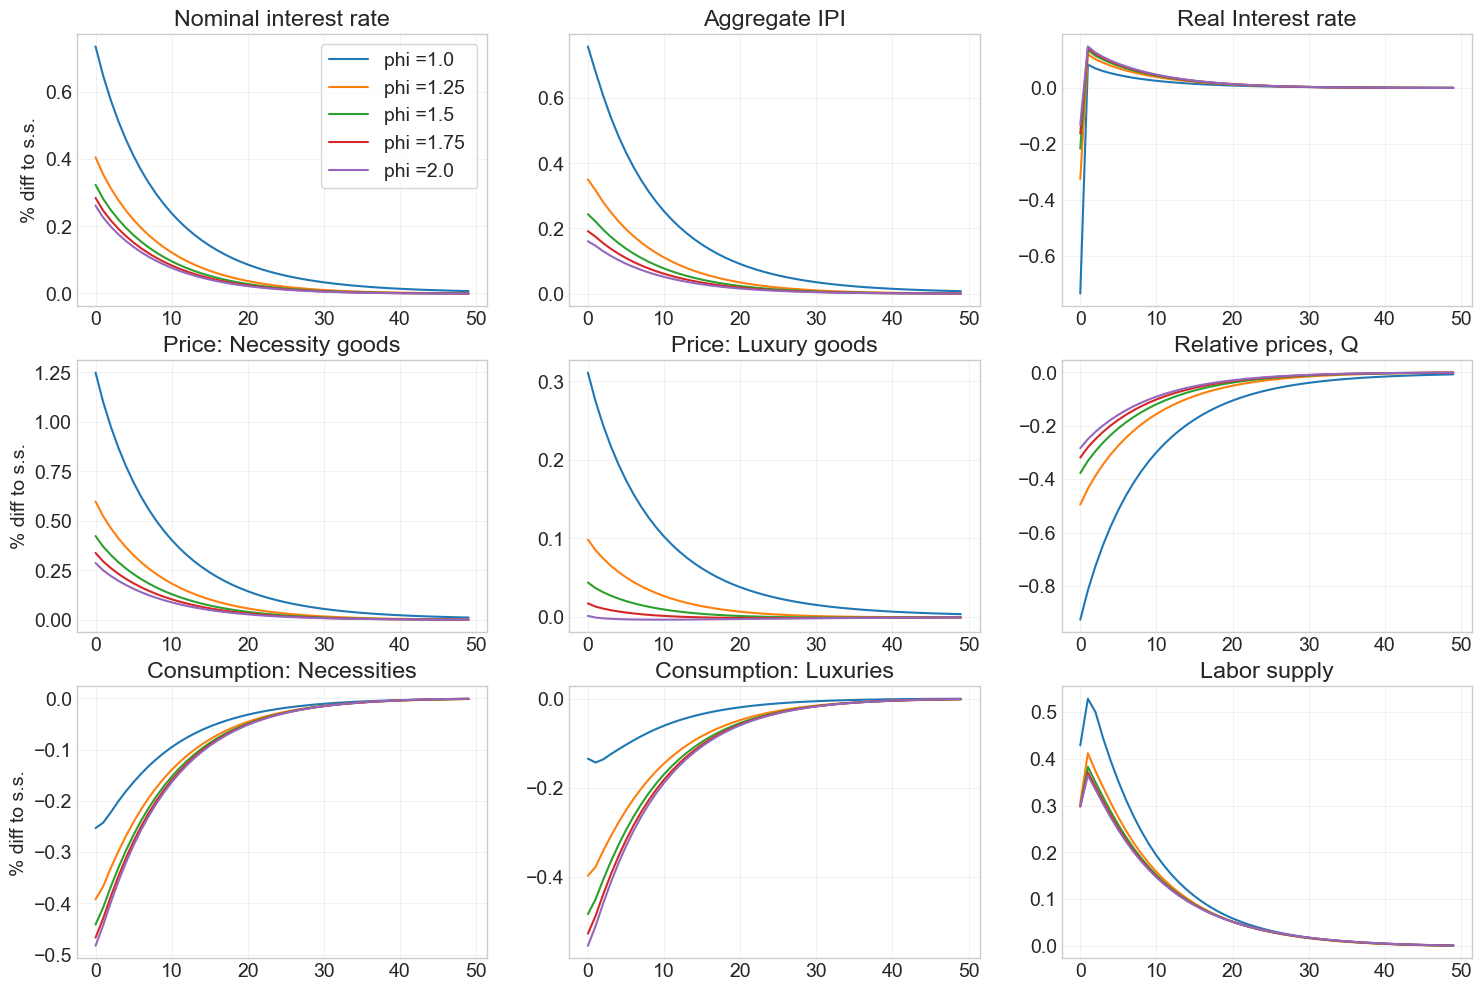

In [74]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Nominal interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.i[0,:50]-b.i[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Aggregate IPI')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,3)
ax.set_title('Real Interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.r[0,:50]-b.r[0,:50])*100)

ax = fig.add_subplot(3,3,4)
ax.set_title('Price: Necessity goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_N[0,:50]-b.p_N[0,:50])/b.p_N[0,:50]*100)
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Price: Luxury goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_L[0,:50]-b.p_L[0,:50])/b.p_L[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Relative prices, Q')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.Q[0,:50]-b.Q[0,:50])/b.Q[0,:50]*100)

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Necessities')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100)
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,8)
ax.set_title('Consumption: Luxuries')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Labor supply')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)


Plots of consumption decompositions by wealth levels:

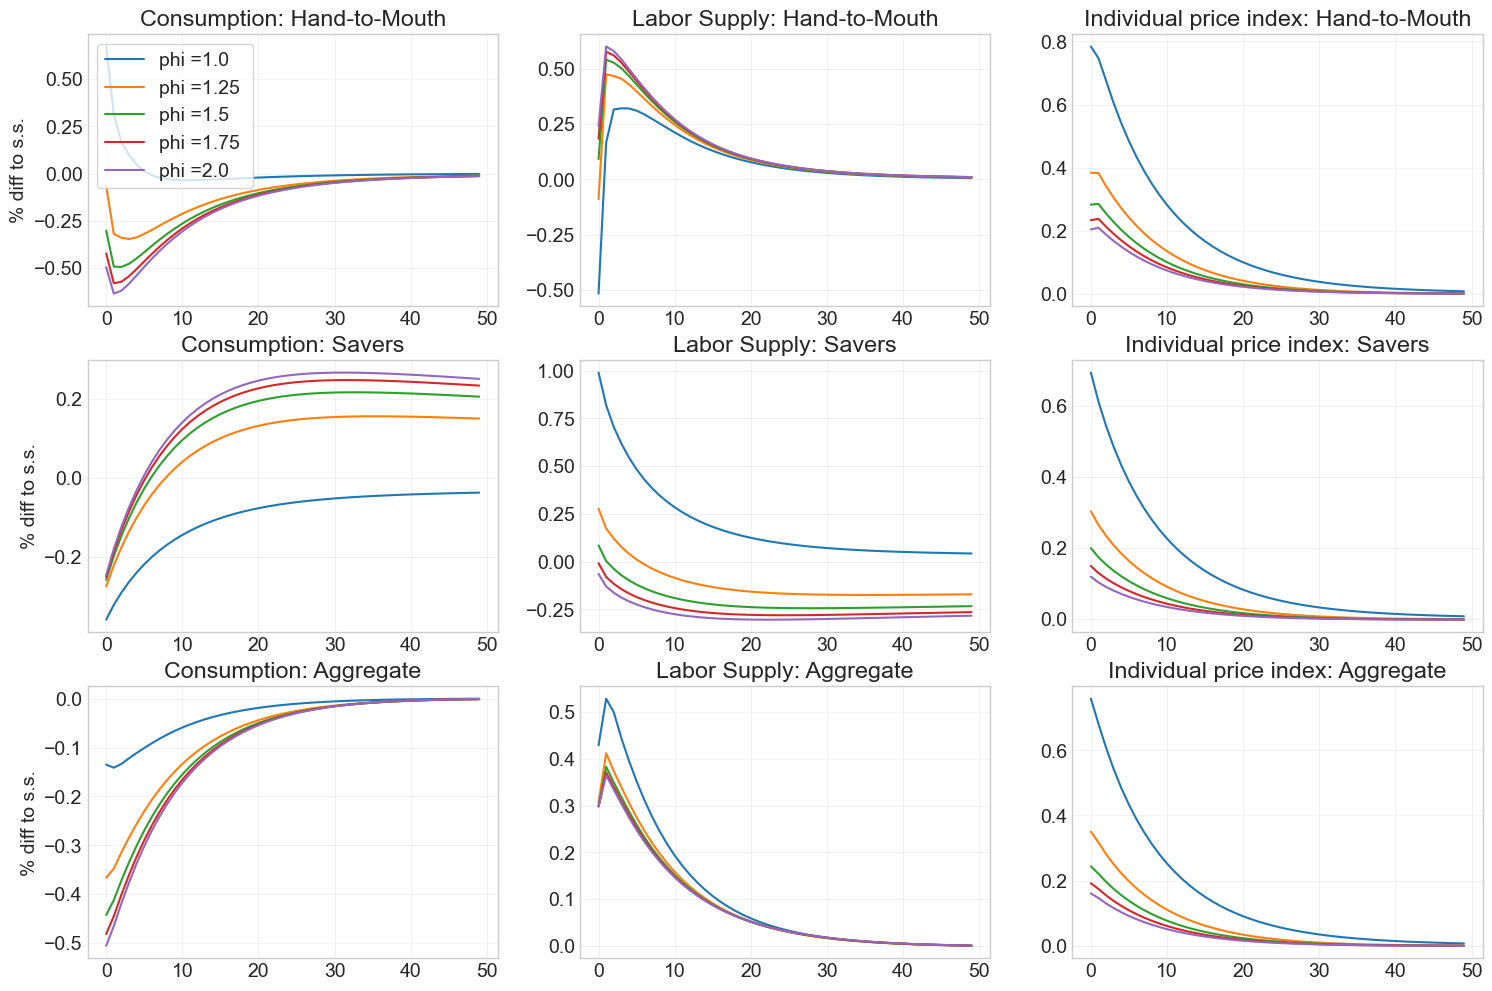

In [75]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,3)
ax.set_title('Individual price index: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,4)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Individual price index: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,8)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Individual price index: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)


### For the one-sector model:

In [76]:
T_max = 50

os_path_alt_poor_list = []
os_path_alt_poor_ss_list = []

os_path_alt_rich_list = []
os_path_alt_rich_ss_list = []

os_path_alt_avg_list = []
os_path_alt_avg_ss_list = []

for i in range(5):
        mod = model_baseline.copy()
        ss = mod.ss
        mod.par.phi = 1+i/4
        mod.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        mod.par.jump_pm     = model.par.jump_pm_N # cost push shock
        mod.compute_jacs()
        mod.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,50:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_poor_list.append(path_alt_poor)
        os_path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_rich_list.append(path_alt_rich)
        os_path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_avg_list.append(path_alt_average)
        os_path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.5000,	 M = 0.4082,	 beta = 0.9875,	 N = 1.2899
Z = 0.6675,	 M = 0.4082,	 beta = 0.9807,	 N = 0.9663
Z = 0.7382,	 M = 0.4082,	 beta = 0.9767,	 N = 0.8737
Z = 0.7824,	 M = 0.4082,	 beta = 0.9731,	 N = 0.8243
Z = 0.7867,	 M = 0.4082,	 beta = 0.9716,	 N = 0.8198
Z = 0.7794,	 M = 0.4082,	 beta = 0.9712,	 N = 0.8275
Z = 0.7730,	 M = 0.4082,	 beta = 0.9711,	 N = 0.8343
Z = 0.7680,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8398
Z = 0.7661,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8419
Z = 0.7662,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8418
Z = 0.7664,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8416
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 0.8417
Z = 0.7663,	 M = 0.4082,	 beta = 0.9710,	 N = 

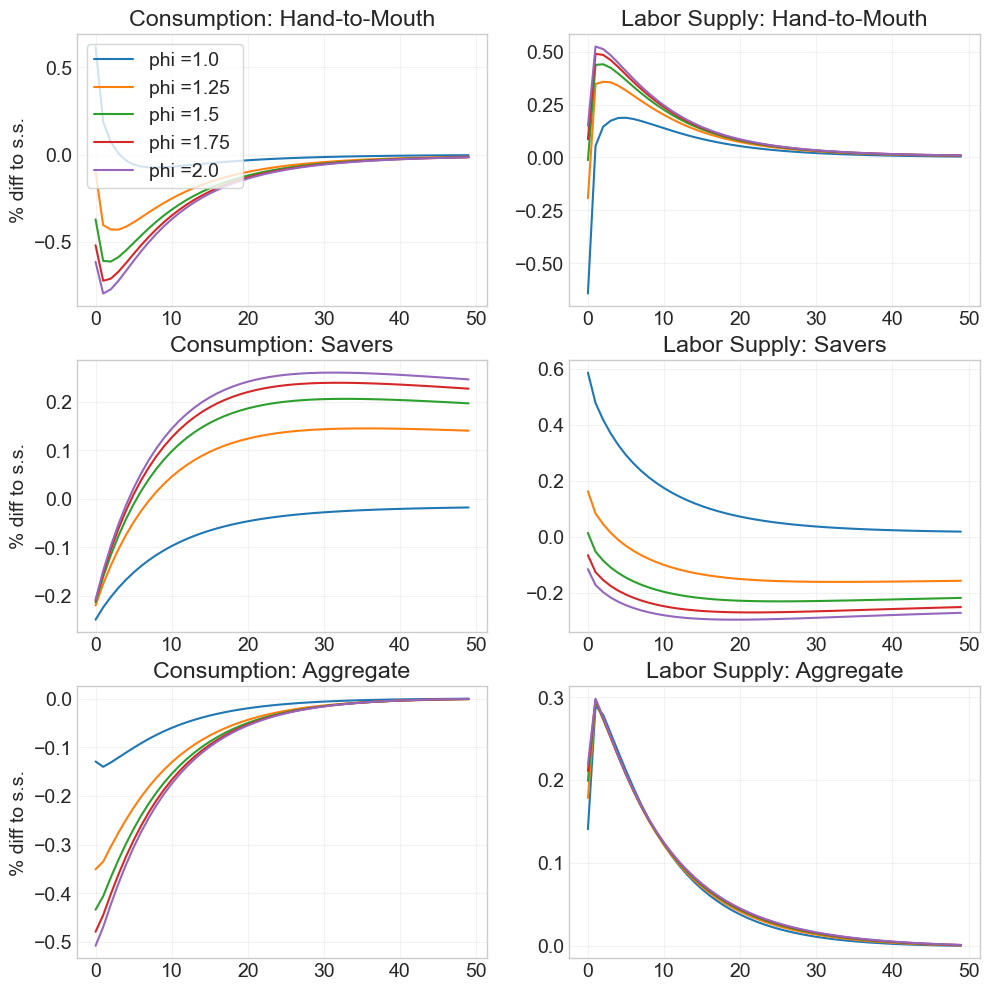

In [77]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

#ax = fig.add_subplot(3,3,3)
#ax.set_title('Individual price index: Hand-to-Mouth')
#for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
#    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,4)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

#ax = fig.add_subplot(3,3,6)
#ax.set_title('Individual price index: Savers')
#for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
#    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,8)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

#ax = fig.add_subplot(3,3,9)
#ax.set_title('Individual price index: Aggregate')
#for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
#    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)


In [78]:
os_path_alt_avg_list

[namespace(a=array([[[[0.00000000e+00, 6.04559301e-04, 2.12941127e-03, ...,
                       9.55147558e+01, 9.66758215e+01, 9.78509349e+01],
                      [4.51936964e-04, 1.94328914e-03, 3.54793417e-03, ...,
                       9.54867508e+01, 9.66477886e+01, 9.78228745e+01],
                      [6.82410535e-03, 9.13361386e-03, 1.15405993e-02, ...,
                       9.54710603e+01, 9.66320396e+01, 9.78070676e+01],
                      ...,
                      [3.02763890e-01, 3.05608520e-01, 3.08487525e-01, ...,
                       9.56375423e+01, 9.67979288e+01, 9.79723676e+01],
                      [9.16847304e-01, 9.19717121e-01, 9.22621617e-01, ...,
                       9.60705250e+01, 9.72298094e+01, 9.84031489e+01],
                      [2.36053107e+00, 2.36340745e+00, 2.36631860e+00, ...,
                       9.72065580e+01, 9.83634147e+01, 9.95343248e+01]]],
             
             
                    [[[0.00000000e+00, 0.00000000e+00, 

In [79]:
#1 sector
#ax.set_title('Consumption: Aggregate')

print('1-sector, rich consumption drop:')
print('Phi = 1',(os_path_alt_rich_list[0].U_hh[0,:5]-os_path_alt_rich_ss_list[0].U_hh[0,:5])/os_path_alt_rich_ss_list[0].U_hh[0,:5]*100)
print('Phi = 2',(os_path_alt_rich_list[4].U_hh[0,:5]-os_path_alt_rich_ss_list[4].U_hh[0,:5])/os_path_alt_rich_ss_list[4].U_hh[0,:5]*100)
print('2-Sector, rich consumption drop:')
print('Phi = 1',(path_alt_rich_list[0].U_hh[0,:5]-path_alt_rich_ss_list[0].U_hh[0,:5])/path_alt_rich_ss_list[0].U_hh[0,:5]*100)
print('Phi = 2',(path_alt_rich_list[4].U_hh[0,:5]-path_alt_rich_ss_list[4].U_hh[0,:5])/path_alt_rich_ss_list[4].U_hh[0,:5]*100)

print('')

print('1-sector, poor consumption drop:')
print('Phi = 1',(os_path_alt_poor_list[0].U_hh[0,:5]-os_path_alt_poor_ss_list[0].U_hh[0,:5])/os_path_alt_poor_ss_list[0].U_hh[0,:5]*100)
print('Phi = 2',(os_path_alt_poor_list[4].U_hh[0,:5]-os_path_alt_poor_ss_list[4].U_hh[0,:5])/os_path_alt_poor_ss_list[4].U_hh[0,:5]*100)
print('2-Sector, poor consumption drop:')
print('Phi = 1',(path_alt_poor_list[0].U_hh[0,:5]-path_alt_poor_ss_list[0].U_hh[0,:5])/path_alt_poor_ss_list[0].U_hh[0,:5]*100)
print('Phi = 2',(path_alt_poor_list[4].U_hh[0,:5]-path_alt_poor_ss_list[4].U_hh[0,:5])/path_alt_poor_ss_list[4].U_hh[0,:5]*100)
print('')
print('I 2-sektor skal fordelen ved lav phi for fattige være større end i 1 sektor')
print('')
print('1-sector, poor labor increase:')
print('Phi = 1',(os_path_alt_poor_list[0].ELL_hh[0,:5]-os_path_alt_poor_ss_list[0].ELL_hh[0,:5])/os_path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
print('Phi = 2',(os_path_alt_poor_list[4].ELL_hh[0,:5]-os_path_alt_poor_ss_list[4].ELL_hh[0,:5])/os_path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
print('2-Sector, poor labor increase:')
print('Phi = 1',(path_alt_poor_list[0].ELL_hh[0,:5]-path_alt_poor_ss_list[0].ELL_hh[0,:5])/path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
print('Phi = 2',(path_alt_poor_list[4].ELL_hh[0,:5]-path_alt_poor_ss_list[4].ELL_hh[0,:5])/path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
#(os_path_alt_avg_list[4].C_hh[0,:50]-os_path_alt_avg_ss_list[4].C_hh[0,:50])/os_path_alt_avg_ss_list[4].C_hh[0,:50]


1-sector, rich consumption drop:
Phi = 1 [0.36852589 0.31554453 0.27884446 0.24795734 0.22135985]
Phi = 2 [ 0.16002648  0.09112291  0.037914   -0.00804703 -0.04817278]
2-Sector, rich consumption drop:
Phi = 1 [0.69110792 0.58523749 0.50848888 0.44768539 0.39624665]
Phi = 2 [ 0.19968155  0.11629473  0.05450902  0.00185954 -0.04373553]

1-sector, poor consumption drop:
Phi = 1 [-1.3922568  -0.11784542  0.03650509  0.088952    0.11940654]
Phi = 2 [0.3606182  1.00138822 0.94843275 0.88053743 0.80708279]
2-Sector, poor consumption drop:
Phi = 1 [-1.54666244 -0.12842807  0.17783945  0.21712636  0.24439953]
Phi = 2 [0.48787923 1.15602447 1.08866357 1.006406   0.91973677]

I 2-sektor skal fordelen ved lav phi for fattige være større end i 1 sektor

1-sector, poor labor increase:
Phi = 1 [-0.64195267  0.05446869  0.14525913  0.17370717  0.18653048]
Phi = 2 [0.14918185 0.5237733  0.5115281  0.4821347  0.44547313]
2-Sector, poor labor increase:
Phi = 1 [-0.5161577   0.16569568  0.31608209  0.3211

## Find effect of parameter change

In [ ]:
#Ensure baseline model has push shock
par.jump_istar      = 0.00 # Monetary policy shock reset
par.jump_pm_N       = 0.01*ss.Q # cost push shock
par.varphi          = 1.5
model.find_transition_path(do_print=False) #all

#CD loading checks
model_one = model.copy()
model_one.par.alpha_N = 0.5
model_one.par.alpha_L = 0.5
model_one.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_one.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.find_ss()
model_one.compute_jacs()
model_one.find_transition_path()

#Mark-up checks
model_two = model.copy()
model_two.par.mu_L = 1.5
model_two.par.mu_N = 1.5
model_two.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_two.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.find_ss()
model_two.compute_jacs()
model_two.find_transition_path()

#Price rigidity checks
model_three = model.copy()
model_three.par.kappa_L = 0.125
model_three.par.kappa_N = 0.125
model_three.par.jump_pm_N     =par.jump_pm_N # cost push shock
model_three.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.find_ss()
model_three.compute_jacs()
model_three.find_transition_path()

#Substitution elasticities check
model_four = model.copy()
model_four.par.gamma_L = 0.5
model_four.par.gamma_N = 0.5
model_four.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_four.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.find_ss()
model_four.compute_jacs()
model_four.find_transition_path()


paths = ['pm_N','P_hh','p_L','p_N','Q','i','r','tau','C_N','C_L','N_N','N_L','M_N','M_L','w_N'] #Show all graphs
model.compare_IRFs([model,model_one,model_two,model_three,model_four],['baseline','alpha_s = 0.5','mu_$s$ = 1.5','kappa_s = 0.125','gamma_s = 0.375'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Nominal interest rate, i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('Inflation, pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('Real interest rate, r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('Aggregate consumption, C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()

Code from old monetary policy experiments

In [ ]:
#model_one   = model.copy()
#model_two   = model.copy()
#model_three = model.copy()
#model_four  = model.copy()
#model_five  = model.copy()
#
#model_list = [model_one,model_two,model_three,model_four,model_five]
##varphi_list = [1.0,1.25,1.50,1.75,2.0]
#
#for i, mod in enumerate(model_list):
#    mod.par.phi = 1+i/4 #Creates varphi-list
#    #mod.par.jump_pm     = par.jump_pm_N # cost push shock
#    mod.par.jump_pm_N     = mod.par.jump_pm_N # cost push shock
#    mod.par.jump_istar = mod.par.jump_istar # Monetary policy shock reset
#    mod.find_ss()
#    mod.compute_jacs()
#    mod.find_transition_path()

In [ ]:
#paths = [['r','pi','C_hh','ELL_hh'],['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q']]
#lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push
#for j,p in enumerate(paths):
#
#    mod_list = []
#    phi_label_list = []
#    for i in range(4):
#        mod = model.copy()
#        mod.par.phi = 1+i/4
#        mod.find_ss()
#        mod.compute_jacs()
#        mod.find_transition_path()
#
#        mod_list.append(mod)
#        phi_label_list.append(f'phi={1+i/4}')
#
#    model.compare_IRFs(mod_list,phi_label_list,p,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2+j)
#    
#    
#

In [ ]:
#paths = ['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

In [ ]:
#paths = ['r','pi','C_hh','ELL_hh'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2)